# **psycopg**

## Part B)

جداول: <br>
جدول مرگ شامل ستون های سال-شماره هفته-جنسیت-سن-تعداد مرگ-شناسه استان <br>
جدول استان شامل ستون های شناسه استان-کداستان-جمعیت <br>

با توجه به کوئری های خواسته شده و تک مقداری بودن جنسیت-سن-استان آن ها را به عنوان ستون در جدول مرگ در نظر گرفتیم و تنها اطلاعات مربوط به استان ها را در جدول دیگر نگه داشتیم و در جدول مرگ یکی کلید خارجی برای استان در نظر گرفتیم تا از افزونگی اطلاعات استان ها جلوگیری کنیم


### Preprocessing

در این قسمت طبق توضیحات بالا جداول مرگ و استان ایجاد شده اند. <br>
برای اضافه کردن جمعیت به جدول استان نیز تعدادی پیش پردازش انجام شده است.

جدول مرگ:

In [4]:
import pandas as pd

data = pd.read_excel(f'../Datasets/weekly-death-by-province-age-group-and-sex-139{5}.xlsx', header=2)
data = data[data.columns[0:7]]
for i in range(6, 10):
    df = pd.read_excel(f'../Datasets/weekly-death-by-province-age-group-and-sex-139{i}.xlsx', header=2)
    df = df[df.columns[0:7]]
    data = pd.concat([data, df])

df_deaths = data
df_deaths.reset_index(inplace=True)
df_deaths.rename(columns={'تعداد مرگ (ثبت شده)': 'تعداد مرگ'}, inplace=True)
df_deaths

,index,سال,شماره هفته,کد استان,استان,جنسیت,سن,تعداد مرگ
0,0,1395,D95W44[951025-951101],P0001,آذربايجان شرقي,زن,0,5
1,1,1395,D95W44[951025-951101],P0001,آذربايجان شرقي,زن,1-4,4
2,2,1395,D95W44[951025-951101],P0001,آذربايجان شرقي,زن,5-9,2
3,3,1395,D95W44[951025-951101],P0001,آذربايجان شرقي,زن,10-14,1
4,4,1395,D95W44[951025-951101],P0001,آذربايجان شرقي,زن,15-19,4
...,...,...,...,...,...,...,...,...
339817,67699,1399,D99W05[990130-990205],P0031,یزد,مرد,75-79,5
339818,67700,1399,D99W05[990130-990205],P0031,یزد,مرد,80-84,8
339819,67701,1399,D99W05[990130-990205],P0031,یزد,مرد,85-89,8
339820,67702,1399,D99W05[990130-990205],P0031,یزد,مرد,90-94,7


جدول استان:

ایجاد جداول

In [5]:
import warnings
warnings.filterwarnings('ignore')
df_population = pd.read_csv('../Datasets/Iran_population.csv')

def regularize_unicode(s):
    s = str(s)
    s = s.replace('ي', 'ی')
    s = s.replace('ك', 'ک')
    a = 'و'
    a = a + ' '
    b = ' '
    b = 'و'
    s = s.replace(a, b)
    return s

df_population['استان‌ها'] = df_population['استان‌ها'].apply(regularize_unicode)
df_population = df_population.rename(columns={'استان‌ها': 'استان'}).set_index('استان')
provinces_columns = ['استان', 'کد استان']
df_deaths['استان'] = df_deaths['استان'].apply(regularize_unicode)
provinces_inf = df_deaths[provinces_columns]
del df_deaths['کد استان']
provinces_inf = provinces_inf.groupby('استان').last()
province_df = provinces_inf.merge(df_population, on='استان', how='outer')
print('merged df shape: ', province_df.shape)
province_df

merged df shape:  (31, 2)


,کد استان,نفر
استان,,
آذربایجان شرقی,P0001,4018000
آذربایجان غربی,P0002,3398000
اردبیل,P0003,1297000
اصفهان,P0004,5292000
البرز,P0005,2865000
ایلام,P0006,597000
بوشهر,P0007,1230000
تهران,P0008,13807000
خراسان جنوبی,P0010,809000


### ایجاد جداول

In [6]:
import psycopg2

def connect():
    return psycopg2.connect(database='Deaths', user='ali', password='ali', host='localhost')

def create_table():

    commands = (
        """
        CREATE TABLE IF NOT EXISTS Province(
            province_id INT GENERATED ALWAYS AS IDENTITY,
            name VARCHAR(255) NOT NULL,
            population INT NOT NULL,
            province_code VARCHAR(255) NOT NULL,
            PRIMARY KEY (province_id)
        )
        """,
        """
        CREATE TABLE IF NOT EXISTS Deaths(
            deaths_id INT GENERATED ALWAYS AS IDENTITY,
            province_id INT NOT NULL,
            death_count INT NOT NULL,
            year INT,
            WEEK VARCHAR(255) NOT NULL,
            SEX VARCHAR(15),
            AGE VARCHAR(100),
            PRIMARY KEY (deaths_id),
            CONSTRAINT fk_province FOREIGN KEY (province_id) REFERENCES Province (province_id)
        )
        """
    )

    conn = None
    try:
        conn = connect()
        cur = conn.cursor()
        for command in commands:
            cur.execute(command)

        cur.close()
        conn.commit()
    
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)

    finally:
        if conn is not None:
            conn.close()

create_table()

اضافه کردن داده ها

In [7]:
class Province:
    def __init__(self, province_id, name, population, province_code):
        self.name = name
        self.population = population
        self.province_code = province_code
        self.province_id = province_id
    
    def __repr__(self):
        return "<Province {}>".format(self.province_id)

    def save_to_db(self):
        with connect() as conn:
            with conn.cursor() as cur:
                cur.execute("""INSERT INTO Province (name, population, province_code) VALUES (%s, %s, %s)""", (self.name, int(self.population), self.province_code))
    
    @classmethod
    def load_from_db_by_id(cls, province_id):
        with connect() as conn:
            with conn.cursor() as cur:
                cur.execute("""SELECT * FROM Province WHERE province_id = %s""", (province_id,))
                province_data = cur.fetchone()
                return cls(*province_data)

In [12]:
class Deaths:
    def __init__(self, deaths_id, province_name, death_count, year, week, sex, age):
        self.deaths_id = deaths_id
        self.province_name = province_name
        self.death_count = death_count
        self.year = year
        self.week = week 
        self.sex = sex
        self.age = age

    def __repr__(self):
        return "<Deaths {}>".format(self.deaths_id)

    def save_to_db(self):
        with connect() as conn:
            with conn.cursor() as cur:
                cur.execute('''INSERT INTO Deaths (province_id, death_count, year, week, sex, age) VALUES
                ((SELECT province_id from province WHERE name=%s), %s, %s, %s, %s, %s)''', (self.province_name, int(self.death_count), int(self.year), self.week, self.sex, self.age))
                # conn.commit()

    @classmethod
    def load_from_db_by_id(cls, deaths_id):
        with connect() as conn:
            with conn.cursor() as cur:
                cur.execute("SELECT * FROM contacts WHERE deaths_id = %s", (deaths_id,))
                deaths_data = cur.fetchone()
                return cls(*deaths_data)

In [9]:
for p in province_df.index:
    province = Province(None, p, province_df.loc[p, 'نفر'], province_df.loc[p, 'کد استان'])
    province.save_to_db()

In [10]:
for i in range(1, 5):
    province = Province.load_from_db_by_id(i)
    print(province.name, province.population, province.province_code)


آذربایجان شرقی 4018000 P0001
آذربایجان غربی 3398000 P0002
اردبیل 1297000 P0003
اصفهان 5292000 P0004


In [13]:
for d in df_deaths.index:
    deaths = Deaths(None, df_deaths.loc[d, 'استان'], df_deaths.loc[d, 'تعداد مرگ'], df_deaths.loc[d, 'سال'], df_deaths.loc[d, 'شماره هفته '], df_deaths.loc[d, 'جنسیت'], df_deaths.loc[d, 'سن'])
    deaths.save_to_db()

## 2) کوئری ها

In [74]:
def execute_query(q):
    with connect() as conn:
            with conn.cursor() as cur:
                cur.execute(q)
                return cur.fetchmany(10)

In [15]:
import matplotlib.pyplot as plt

### 2.a)

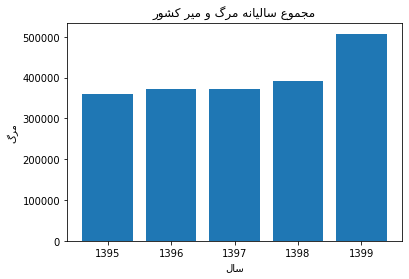

In [54]:
from bidi.algorithm import get_display
from arabic_reshaper import reshape

DEATHS_PER_YEAR = """
SELECT year, SUM(death_count) AS deaths
FROM Deaths
GROUP BY year
ORDER BY year ASC
"""

result = execute_query(DEATHS_PER_YEAR)

plt.bar([x[0] for x in result], [x[1] for x in result])
plt.xlabel(get_display(reshape('سال')))
plt.ylabel(get_display(reshape('مرگ')))
plt.title(get_display(reshape('مجموع سالیانه مرگ و میر کشور')));

### 2.b)

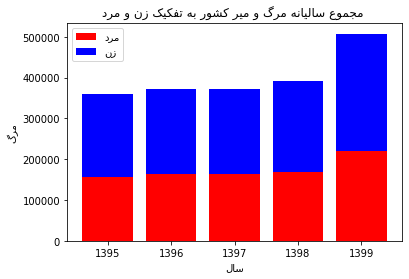

In [59]:
DEATHS_PER_YEAR_PER_SEX= f"""
SELECT year, sex,  SUM(death_count)
FROM deaths
GROUP BY year, sex
ORDER BY sex, year  ASC

"""

result = execute_query(DEATHS_PER_YEAR_PER_SEX)

result_men = result[:int(len(result)/2)]
result_women = result[int(len(result)/2):]

plt.bar([x[0] for x in result_men], [x[2] for x in result_men], color='r', label=get_display(reshape('مرد')))
plt.bar([x[0] for x in result_women], [x[2] for x in result_women], bottom=[x[2] for x in result_men], color='b', label=get_display(reshape('زن')))
plt.legend()
plt.xlabel(get_display(reshape('سال')))
plt.ylabel(get_display(reshape('مرگ')))
plt.title(get_display(reshape(' مجموع سالیانه مرگ و میر کشور به تفکیک زن و مرد')));

### 2.c)

Text(0.5, 1.0, '۱۳۹۹ ﻝﺎﺳ ﺭﺩ ﺪﻟﻮﺗ ﻭﺪﺑ ﺭﺩ ﮒﺮﻣ ﺩﺍﺪﻌﺗ ﻦﯾﺮﺘﺸﯿﺑ ﺎﺑ ﯼﺎﻫ ﻥﺎﺘﺳﺍ')

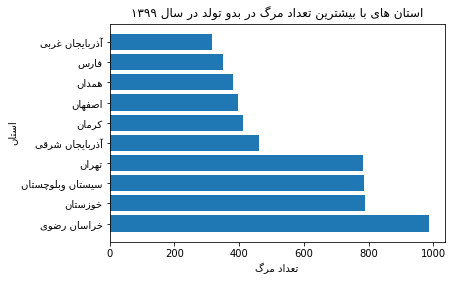

In [52]:
PROVINCE_WITH_MOST_DEATHS = """
SELECT province.name, sum(death_count)
from deaths
inner join province on deaths.province_id = province.province_id
where deaths.year = 1399 and age = '0'
group by province.province_id
order by sum(death_count) desc
"""
result = execute_query(PROVINCE_WITH_MOST_DEATHS)

plt.barh([get_display(reshape(x[0])) for x in result], [x[1] for x in result])
plt.ylabel(get_display(reshape('استان')))
plt.xlabel(get_display(reshape('تعداد مرگ')))
plt.title(get_display(reshape('استان های با بیشترین تعداد مرگ در بدو تولد در سال ۱۳۹۹')))

### 2.d)

Text(0.5, 1.0, '۱۳۹۹ ﻝﺎﺳ ﺭﺩ ﻥﺎﻧﺯ ﮒﺮﻣ ﺩﺍﺪﻌﺗ ﻦﯾﺮﺘﺸﯿﺑ ﺎﺑ ﯼﺎﻫ ﻥﺎﺘﺳﺍ')

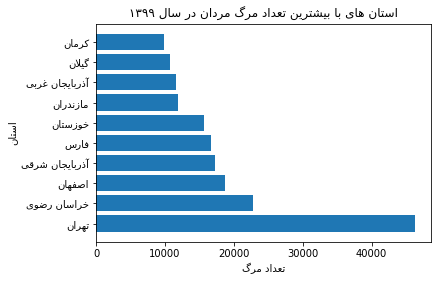

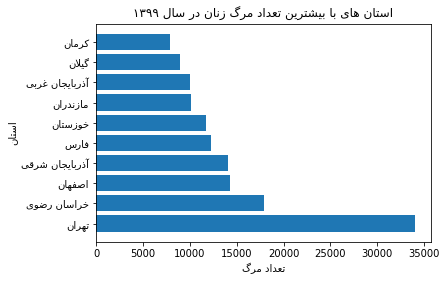

In [62]:
PROVINCE_WITH_MOST_DEATHS_MEN = """
SELECT province.name, sum(death_count)
from deaths
inner join province on deaths.province_id = province.province_id
where deaths.year = 1399 and sex = 'مرد'
group by province.province_id
order by sum(death_count) desc
"""
result_men = execute_query(PROVINCE_WITH_MOST_DEATHS_MEN)

plt.barh([get_display(reshape(x[0])) for x in result_men], [x[1] for x in result_men])
plt.ylabel(get_display(reshape('استان')))
plt.xlabel(get_display(reshape('تعداد مرگ')))
plt.title(get_display(reshape('استان های با بیشترین تعداد مرگ مردان در سال ۱۳۹۹')))

plt.figure()

PROVINCE_WITH_MOST_DEATHS_WOMEN = """
SELECT province.name, sum(death_count)
from deaths
inner join province on deaths.province_id = province.province_id
where deaths.year = 1399 and sex = 'زن'
group by province.province_id
order by sum(death_count) desc
"""
result_women = execute_query(PROVINCE_WITH_MOST_DEATHS_WOMEN)

plt.barh([get_display(reshape(x[0])) for x in result_women], [x[1] for x in result_women])
plt.ylabel(get_display(reshape('استان')))
plt.xlabel(get_display(reshape('تعداد مرگ')))
plt.title(get_display(reshape('استان های با بیشترین تعداد مرگ زنان در سال ۱۳۹۹')))


### 2.e

Text(0.5, 1.0, '۱۳۹۵ ﻝﺎﺳ ﺭﺩ ﺪﻟﻮﺗ ﻭﺪﺑ ﺭﺩ ﮒﺮﻣ ﺩﺍﺪﻌﺗ ﻦﯾﺮﺘﺸﯿﺑ ﺎﺑ ﯼﺎﻫ ﻥﺎﺘﺳﺍ')

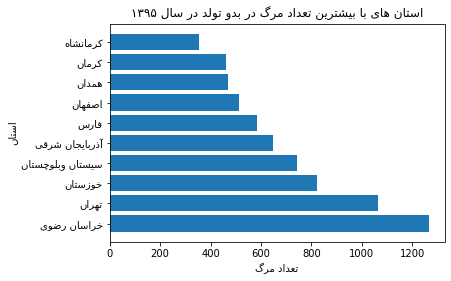

In [63]:

PROVINCE_WITH_MOST_DEATHS = """
SELECT province.name, sum(death_count)
from deaths
inner join province on deaths.province_id = province.province_id
where deaths.year = 1395 and age = '0'
group by province.province_id
order by sum(death_count) desc
"""
result = execute_query(PROVINCE_WITH_MOST_DEATHS)

plt.barh([get_display(reshape(x[0])) for x in result], [x[1] for x in result])
plt.ylabel(get_display(reshape('استان')))
plt.xlabel(get_display(reshape('تعداد مرگ')))
plt.title(get_display(reshape('استان های با بیشترین تعداد مرگ در بدو تولد در سال ۱۳۹۵')))

### 2.f)

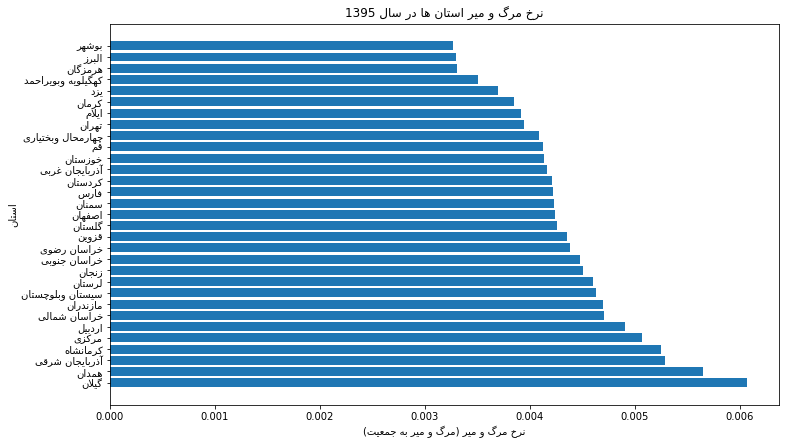

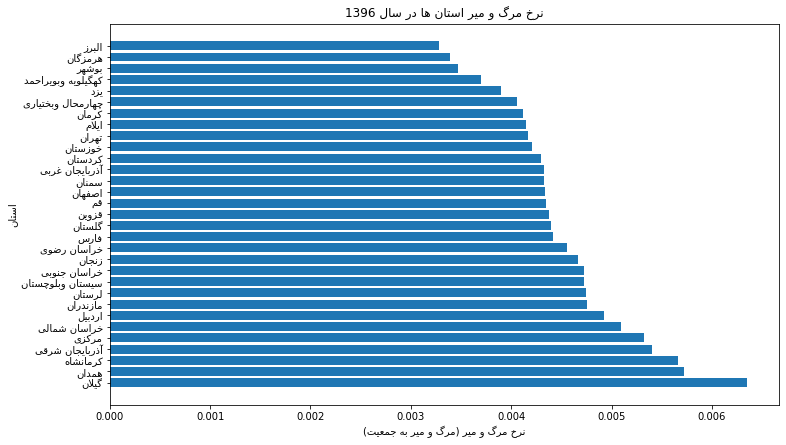

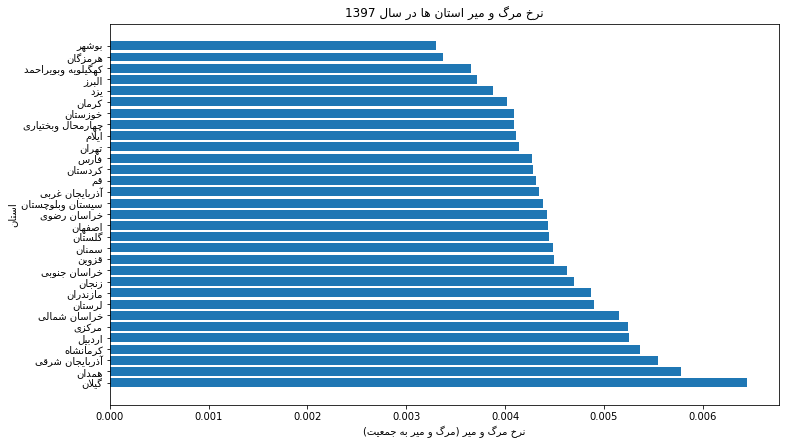

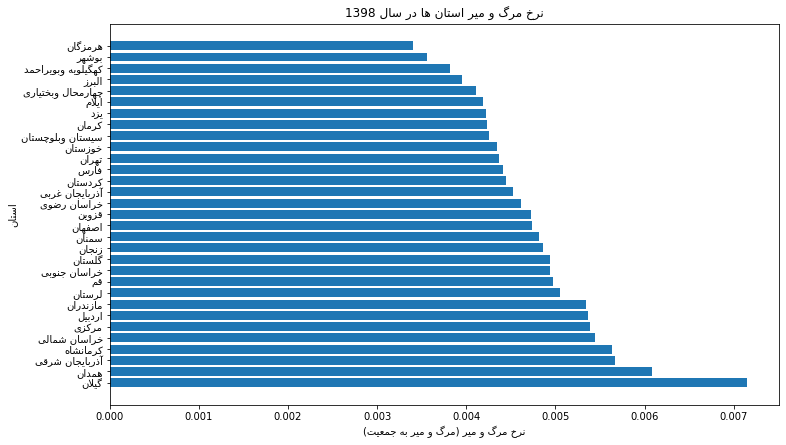

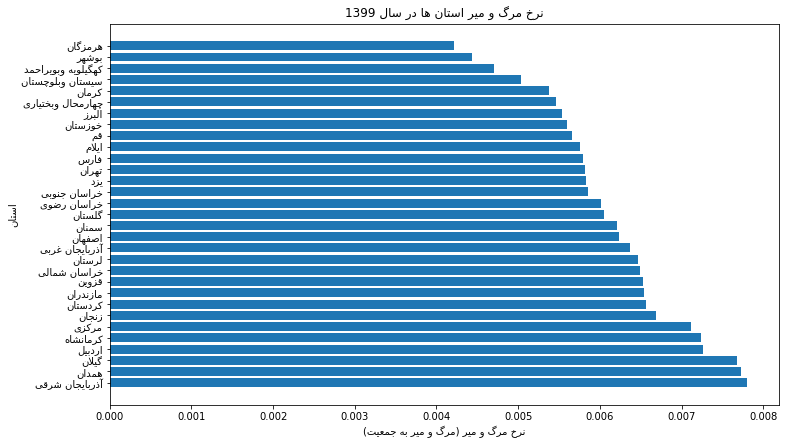

In [76]:
for i in range(5, 10):

    PROVINCE_DEATH_RATE = f"""
    SELECT province.name, cast(sum(death_count) as decimal) / province.population
    from deaths
    inner join province on deaths.province_id = province.province_id
    where deaths.year = 139{i}
    group by province.province_id
    order by cast(sum(death_count) as decimal) / province.population desc
    """
    result = execute_query(PROVINCE_DEATH_RATE)

    plt.figure(figsize=(12, 7))
    plt.barh([get_display(reshape(x[0])) for x in result], [x[1] for x in result])
    plt.ylabel(get_display(reshape('استان')))
    plt.xlabel(get_display(reshape('نرخ مرگ و میر (مرگ و میر به جمعیت)')))
    plt.title(get_display(reshape(f'نرخ مرگ و میر استان ها در سال 139{i}')))


### 3) تحلیل نتایج

۱- مجموع مرگ سالیانه کشور به وضوح در سال ۹۹ افزایش یافته است که میتواند به علت مرگ ناشی از بیماری کرونا باشد. <br>

۲- مرگ زنان از مردان همیشه بیشتر بوده و این نسبت به هنگام بیماری کرونا در سال ۹۹ نیز تقریبا ثابت مانده است. <br>

۳- تعداد مرگ در بدو تولد در استان خراسان رضوی هر دو سال ۹۹ و ۹۵ اختلاف چشم گیری با بقیه استان ها دارد که شاید در کل میتواند به علت تولد زیاد در این استان باش. <br>

۴- استان های تهران و خراسان و اصفهان بیشترین مرگ را در سال ۹۹ داشته اند. <br>

۵- ترتیب استان ها در نرخ مرگ و میر در سال های مختلف تغییر چندانی نکرده است اما به وضوح به خاطر بیماری کرونا در سال ۹۹ افزایش یافته است 

### 4)

کانکشن زیاد به دیتابیس بسیار زمان بر است.
در مواقعی مانند افزودن داده ها به دیتابیس روش درست این است که به صورت دسته ای داده ها افزوده شود تا نیز نباشد برای هر افزودن داده یک کانکشن جدید به دیتابیس زده شود